In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from gtda.pipeline import Pipeline
from gtda.time_series import Resampler
from gtda.diagrams import PersistenceEntropy, Scaler, HeatKernel
import numpy as np
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters, TakensEmbedding
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud

We start by analyzing the public data set and looking at the normal operations time series, to set a benchmark for the analysis of well events (abnormal operations). 

In [2]:
def find_shortest_file(path, label):
    tmp = []
    os.chdir(path)
    for file in os.listdir():
        data_df = pd.read_csv(file)
        tmp.append(len(data_df[label]))
    return min(tmp)

In [3]:
def read_files(path, label, limit):
    data = []
    os.chdir(path)
    for file in os.listdir():
        data_df = pd.read_csv(file)
        # fill NaN with an interpolated value
        data_df = data_df.interpolate()
        period = int(len(data_df)/limit)
        periodicSampler = Resampler(period=period)
        # print(file, len(data_df), limit, 'resampled to period:', period)
        # resample the files to that all of them are the same length (in entries)
        # NOTE: timestamps are omitted and timesteps are going to be different for each resampled time series!
        index_sampled, signal_sampled = periodicSampler.fit_transform_resample(data_df.index, data_df[label])
        data.append(signal_sampled)
    data_T = list(map(list, zip(*data)))
    df = pd.DataFrame.from_records(data_T)
    return data, df

In [4]:
find_shortest_file("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0", "P-TPT")

7010

In [5]:
normal_signals, normal_df = read_files("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/3/test/", "P-TPT",7000)

In [6]:
normal_df

0           1           2           3           4           5   \
0     15923800.0  16364360.0  14545720.0  15763660.0  14563290.0  16229530.0   
1     15922750.0  16364060.0  14547290.0  15764790.0  14569010.0  16229930.0   
2     15919480.0  16363760.0  14548100.0  15765470.0  14574370.0  16230460.0   
3     15917740.0  16363680.0  14549470.0  15765660.0  14580420.0  16229520.0   
4     15915620.0  16363170.0  14551070.0  15765550.0  14586440.0  16227970.0   
...          ...         ...         ...         ...         ...         ...   
7188  16260620.0  13566170.0  14035410.0  15582750.0  14387800.0  16158000.0   
7189  16260160.0  13565000.0  14034980.0  15584210.0  14389690.0  16158640.0   
7190  16259370.0  13563580.0  14034560.0  15585860.0  14390100.0  16158600.0   
7191  16258320.0  13562280.0  14032780.0  15586940.0  14390510.0  16158400.0   
7192  16257880.0  13560960.0  14031690.0  15587630.0  14391640.0  16158730.0   

              6           7           8           9   ...          22  \
0     15593270.0  14071870.0  15840130.0  14177770.0  ...  13829370.0   
1     15594470.0  14072490.0  15835860.0  14180130.0  ...  13831460.0   
2     15595040.0  14073110.0  15831000.0  14181480.0  ...  13834500.0   
3     15596120.0  14073730.0  15826460.0  14182840.0  ...  13835520.0   
4     15597960.0  14074350.0  15821460.0  14184290.0  ...  13836550.0   
...          ...         ...         ...         ...  ...         ...   
7188  15442280.0  14401780.0  15356000.0  13675140.0  ...  15691050.0   
7189  15443960.0  14401610.0  15355380.0  13679990.0  ...  15693170.0   
7190  15448060.0  14401450.0  15355350.0  13683920.0  ...  15693520.0   
7191  15450020.0  14401280.0  15354660.0  13689960.0  ...  15693870.0   
7192  15451260.0  14401120.0  15353200.0  13695990.0  ...  15695210.0   

              23          24          25          26          27          28  \
0     15829460.0  16268030.0  14860340.0  14000140.0  15411580.0  14999240.0   
1     15829570.0  16267610.0  14862510.0  13999600.0  15413760.0  15000900.0   
2     15830900.0  16266600.0  14864270.0  14001830.0  15415820.0  15002530.0   
3     15832080.0  16265250.0  14866440.0  14004050.0  15417560.0  15002860.0   
4     15833980.0  16264630.0  14869060.0  14006950.0  15419050.0  15003200.0   
...          ...         ...         ...         ...         ...         ...   
7188  15673150.0  16394380.0  16244210.0  13457780.0  14695360.0  16518330.0   
7189  15674830.0  16393680.0  16246170.0  13459000.0  14696690.0  16520030.0   
7190  15676190.0  16392530.0  16247070.0  13459610.0  14697940.0  16520740.0   
7191  15676980.0  16391840.0  16248290.0  13460370.0  14699370.0  16521320.0   
7192  15678580.0  16391920.0  16250360.0  13461490.0  14701040.0  16521780.0   

              29          30          31  
0     15915160.0  14880540.0  13445530.0  
1     15915820.0  14881900.0  13445620.0  
2     15916020.0  14883270.0  13445310.0  
3     15916260.0  14886550.0  13444600.0  
4     15916490.0  14890560.0  13444890.0  
...          ...         ...         ...  
7188  14214890.0  13250120.0  13840370.0  
7189  14215670.0  13247410.0  13841330.0  
7190  14217140.0  13244900.0  13842050.0  
7191  14218690.0  13240890.0  13842600.0  
7192  14221560.0  13236300.0  13843500.0  

[7193 rows x 32 columns]

In [9]:
signal = normal_df[0]
max_time_delay = 200
max_embedding_dimension = 30
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay


embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=-1, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

Optimal embedding time delay based on mutual information: 200
Optimal embedding dimension based on false nearest neighbors: 15


In [628]:
embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay
stride = 1

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)

batch_pca =  CollectionTransformer(PCA(n_components=3),n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1], n_jobs=None)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)

In [638]:
steps = [
         ("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
        # ("scaling", scaling),
        # ("entropy", entropy)
        ]
topological_transfomer = Pipeline(steps)

In [ ]:
features = topological_transfomer.fit_transform(normal_df.T)

In [ ]:
plot_point_cloud(features[11])

In [ ]:
persistence.fit_transform_plot(features[11])

In [513]:
steps = [("resampler", resampler),
        # ("embedder", embedder),
        # ("pca", batch_pca),
        # ("persistence", persistence),
        # ("scaling", scaling),
        # ("entropy", entropy)
        ]
topological_transfomer = Pipeline(steps)

In [517]:
features = topological_transfomer.fit_transform(normal_df)
features.shape

(1000, 2)

In [519]:
features

array([[14071870., 13967300.],
       [14074970., 13964140.],
       [14078060., 13961050.],
       ...,
       [14309280., 13735550.],
       [14319180., 13732060.],
       [14329070., 13728720.]])

features is now a downsampled 

In [561]:
steps = [#("resampler", resampler),
         ("embedder", embedder),
         ("pca", batch_pca),
         #("persistence", persistence),
         #("scaling", scaling),
         #("entropy", entropy)
        ]
topological_transfomer = Pipeline(steps)

In [526]:
features_new = topological_transfomer.fit_transform(features.T)
features_new.shape

(2, 950, 3)

In [539]:
plot_point_cloud(features_new[0])

Just checking by comparing with a single embedding 

In [622]:
slug_data_single_df = pd.read_csv("/Users/simo/repos/RareEventsDataset/3w_dataset-master/data/data/0/test/WELL-00001_20170320130025.csv")
signal = slug_data_single_df["P-TPT"]

In [623]:
optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=optimal_embedding_dimension, time_delay=optimal_time_delay, dimension=6, stride=stride
)

signal_embedded = embedder.fit_transform(signal)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

Optimal embedding time delay based on mutual information: 289
Optimal embedding dimension based on false nearest neighbors: 9


In [541]:
signal_embedded_pca.shape

(1748, 3)

In [124]:
normal_data_df = pd.read_csv("../RareEventsDataset/3w_dataset-master/data/data/0/WELL-00004_20140807000129.csv")

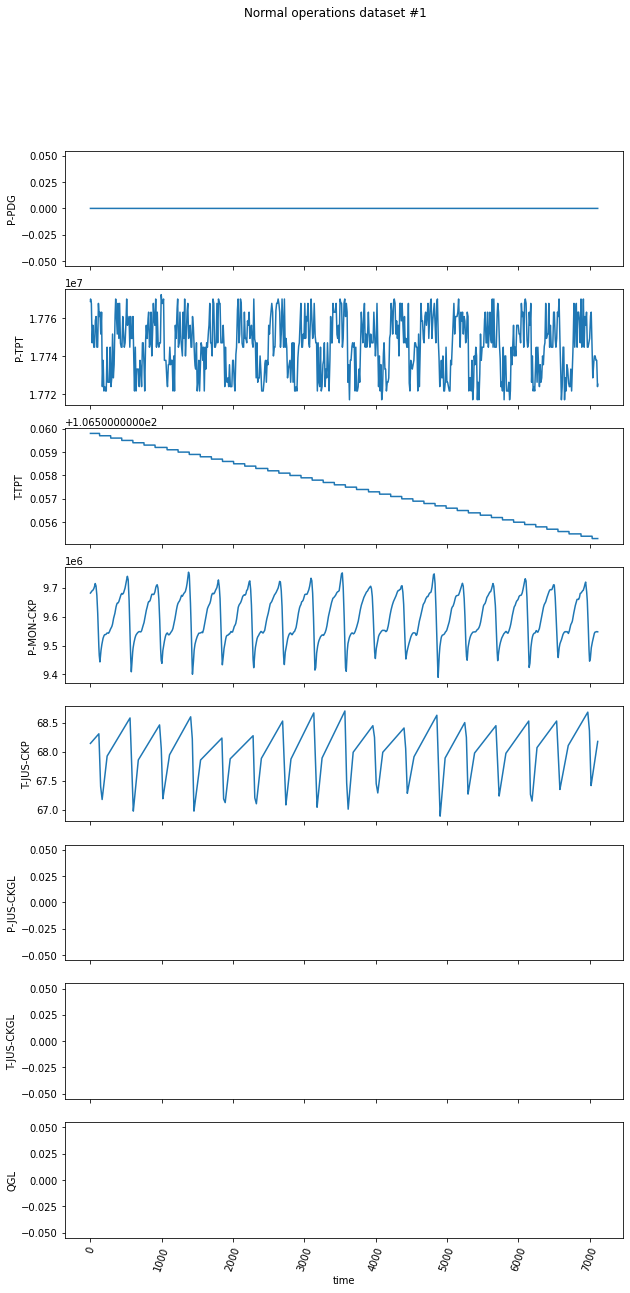

In [125]:
fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Normal operations dataset #1')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(normal_data_df.index, normal_data_df["P-PDG"])
ts[1].plot(normal_data_df.index, normal_data_df["P-TPT"])
ts[2].plot(normal_data_df.index, normal_data_df["T-TPT"])
ts[3].plot(normal_data_df.index, normal_data_df["P-MON-CKP"])
ts[4].plot(normal_data_df.index, normal_data_df["T-JUS-CKP"])
ts[5].plot(normal_data_df.index, normal_data_df["P-JUS-CKGL"])
ts[6].plot(normal_data_df.index, normal_data_df["T-JUS-CKGL"])
ts[7].plot(normal_data_df.index, normal_data_df["QGL"])

In [53]:
slug_data_df = pd.read_csv("../RareEventsDataset/3w_dataset-master/data/data/3/WELL-00001_20170320130025.csv")

In [54]:
slug_data_df

timestamp  P-PDG       P-TPT     T-TPT  P-MON-CKP  \
0      2017-03-20 13:00:25.000000    0.0  14071870.0  117.1827  6085929.0   
1      2017-03-20 13:00:26.000000    0.0  14072180.0  117.1828  6087002.0   
2      2017-03-20 13:00:27.000000    0.0  14072490.0  117.1829  6088075.0   
3      2017-03-20 13:00:28.000000    0.0  14072800.0  117.1830  6089148.0   
4      2017-03-20 13:00:29.000000    0.0  14073110.0  117.1831  6090221.0   
...                           ...    ...         ...       ...        ...   
17971  2017-03-20 17:59:56.000000    0.0  14055950.0  116.8203  6025813.0   
17972  2017-03-20 17:59:57.000000    0.0  14055620.0  116.8200  6025539.0   
17973  2017-03-20 17:59:58.000000    0.0  14055290.0  116.8197  6025265.0   
17974  2017-03-20 17:59:59.000000    0.0  14054970.0  116.8194  6024990.0   
17975  2017-03-20 18:00:00.000000    0.0  14054640.0  116.8192  6024716.0   

       T-JUS-CKP  P-JUS-CKGL  T-JUS-CKGL  QGL  class  
0       69.02943   3245327.0         NaN  0.0      3  
1       69.03323   3245327.0         NaN  0.0      3  
2       69.03702   3245327.0         NaN  0.0      3  
3       69.04082   3245327.0         NaN  0.0      3  
4       69.04462   3245327.0         NaN  0.0      3  
...          ...         ...         ...  ...    ...  
17971   70.36837   3246232.0         NaN  0.0      3  
17972   70.36488   3246232.0         NaN  0.0      3  
17973   70.36140   3246232.0         NaN  0.0      3  
17974   70.35791   3246232.0         NaN  0.0      3  
17975   70.35443   3246232.0         NaN  0.0      3  

[17976 rows x 10 columns]

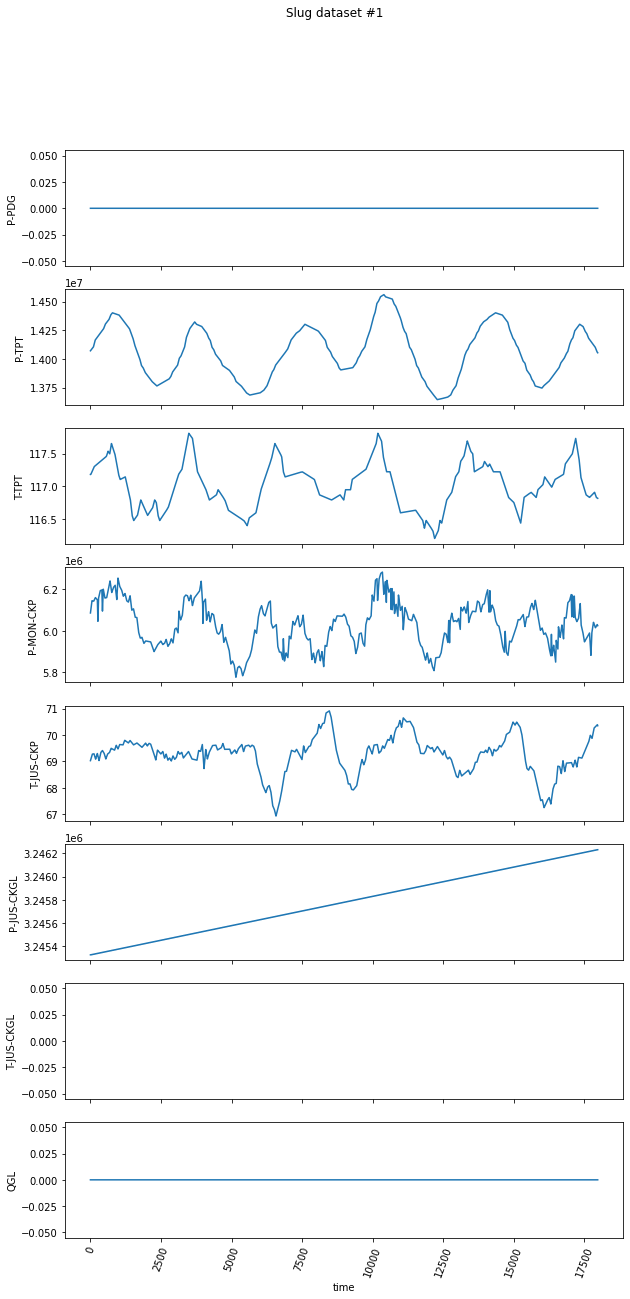

In [55]:
fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Slug dataset #1')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(slug_data_df.index, slug_data_df["P-PDG"])
ts[1].plot(slug_data_df.index, slug_data_df["P-TPT"])
ts[2].plot(slug_data_df.index, slug_data_df["T-TPT"])
ts[3].plot(slug_data_df.index, slug_data_df["P-MON-CKP"])
ts[4].plot(slug_data_df.index, slug_data_df["T-JUS-CKP"])
ts[5].plot(slug_data_df.index, slug_data_df["P-JUS-CKGL"])
ts[6].plot(slug_data_df.index, slug_data_df["T-JUS-CKGL"])
ts[7].plot(slug_data_df.index, slug_data_df["QGL"])


In [385]:
period = 20
periodicSampler = Resampler(period=period)
signal = slug_data_df["P-TPT"]

#slug_data_df.index, slug_data_df["P-TPT"]
index_sampled, signal_sampled = periodicSampler.fit_transform_resample(slug_data_df.index, signal)

#print(index_sampled, signal_sampled, len(signal_sampled))

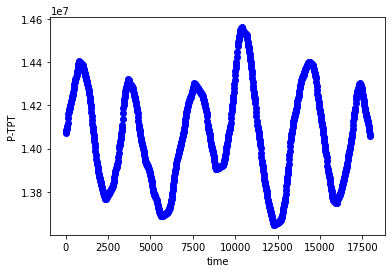

In [57]:
signal_downsampled = pd.DataFrame(signal_sampled,
                  index=index_sampled, columns=['P-TPT'])
#signal_downsampled['P-TPT']
plt.xlabel('time');
plt.ylabel('P-TPT');
plt.plot(signal_downsampled.index,signal_downsampled['P-TPT'], 'bo-')

In [126]:

print('length of signal to analyze', len(signal_downsampled))

max_time_delay = 300 
max_embedding_dimension = 30
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal_downsampled, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_embedded = embedder.fit_transform(signal_downsampled)

pca = PCA(n_components=3)
signal_embedded_pca = pca.fit_transform(signal_embedded)

plot_point_cloud(signal_embedded_pca)

length of signal to analyze 899
Optimal embedding time delay based on mutual information: 27
Optimal embedding dimension based on false nearest neighbors: 17


In [59]:
from gtda.homology import VietorisRipsPersistence
homology_dimensions = (0, 1, 2)
VRP = VietorisRipsPersistence(homology_dimensions=homology_dimensions)

signal_embedded_reshaped = signal_embedded.reshape(1, *signal_embedded.shape)
print(f"y_wn_embedded_reshaped.shape",signal_embedded_reshaped.shape)
print(f"y_wn_embedded.shape", signal_embedded.shape)

PerHom_signal = VRP.fit_transform(signal_embedded_reshaped)
VRP.plot(PerHom_signal)

y_wn_embedded_reshaped.shape (1, 467, 17)
y_wn_embedded.shape (467, 17)


In [60]:
PE_slug = PersistenceEntropy()
PE_slug_norm = PersistenceEntropy(normalize=True)
features = PE_slug.fit_transform(PerHom_signal)
features_norm = PE_slug_norm.fit_transform(PerHom_signal)

In [61]:
features

array([[8.85156327, 2.40306284, 4.83440879]])

In [62]:
features_norm

array([[0.36769906, 0.11765671, 0.27278366]])

In [63]:
slug_data_sim_df = pd.read_csv("../RareEventsDataset/3w_dataset-master/data/data/3/SIMULATED_00013.csv")

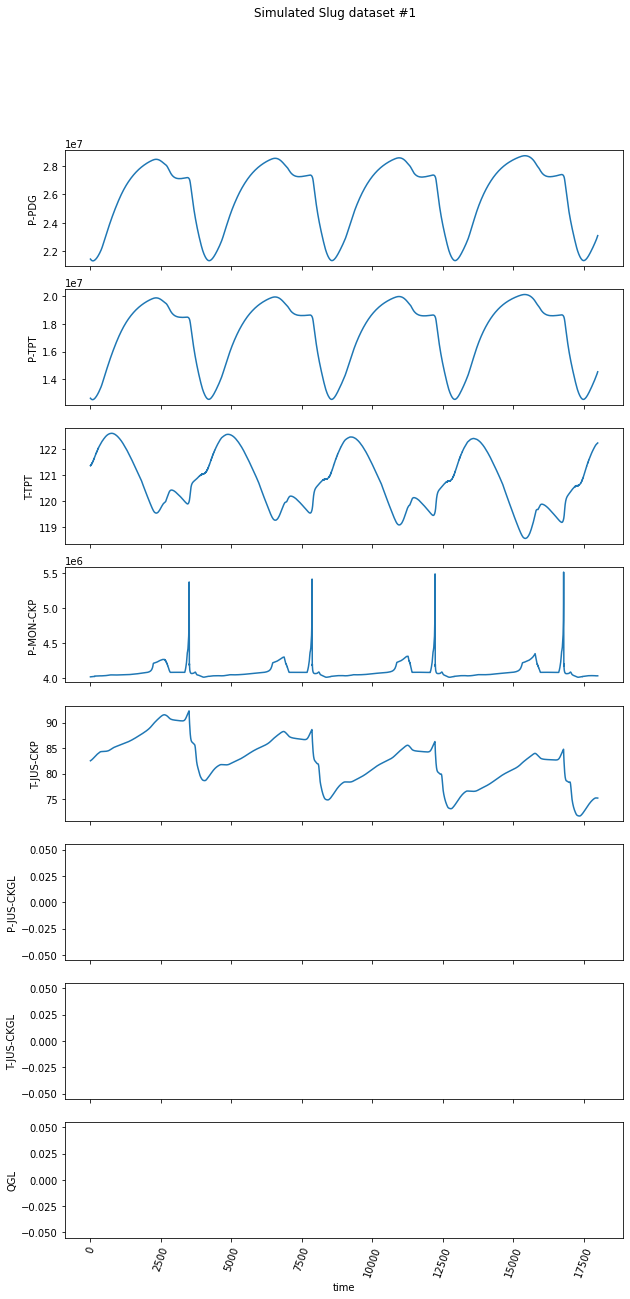

In [64]:
slug_data_sim_df = slug_data_sim_df.head(18000)

fig, ts = plt.subplots(8,figsize=(10,20),sharex = True)

fig.suptitle('Simulated Slug dataset #1')
ts[7].set_xlabel('time')
ts[0].set_ylabel("P-PDG")
ts[1].set_ylabel('P-TPT')
ts[2].set_ylabel('T-TPT')
ts[3].set_ylabel("P-MON-CKP")
ts[4].set_ylabel('T-JUS-CKP')
ts[5].set_ylabel('P-JUS-CKGL')
ts[6].set_ylabel("T-JUS-CKGL")
ts[7].set_ylabel('QGL')

degrees = 70
plt.xticks(rotation=degrees)

ts[0].plot(slug_data_sim_df.index, slug_data_sim_df["P-PDG"])
ts[1].plot(slug_data_sim_df.index, slug_data_sim_df["P-TPT"])
ts[2].plot(slug_data_sim_df.index, slug_data_sim_df["T-TPT"])
ts[3].plot(slug_data_sim_df.index, slug_data_sim_df["P-MON-CKP"])
ts[4].plot(slug_data_sim_df.index, slug_data_sim_df["T-JUS-CKP"])
ts[5].plot(slug_data_sim_df.index, slug_data_sim_df["P-JUS-CKGL"])
ts[6].plot(slug_data_sim_df.index, slug_data_sim_df["T-JUS-CKGL"])
ts[7].plot(slug_data_sim_df.index, slug_data_sim_df["QGL"])


In [65]:
period = 20
periodicSampler = Resampler(period=period)
signal = slug_data_sim_df["P-TPT"]

slug_data_sim_df.index, slug_data_sim_df["P-TPT"]
index_sampled, signal_sim_sampled = periodicSampler.fit_transform_resample(slug_data_sim_df.index, signal)


In [66]:
signal_sim_sampled

array([12632460., 12584720., 12551450., 12532900., 12528950., 12538280.,
       12559700., 12591610., 12632220., 12680630., 12735770., 12797520.,
       12864970., 12937750., 13015390., 13097370., 13183300., 13272980.,
       13366530., 13466430., 13578660., 13699310., 13829580., 13958740.,
       14091240., 14222930., 14353900., 14484490., 14613790., 14742200.,
       14869370., 14994930., 15120020., 15242630., 15363650., 15483060.,
       15600650., 15716220., 15829140., 15941130., 16050940., 16159480.,
       16266670., 16372180., 16476430., 16578660., 16679810., 16778580.,
       16875750., 16971250., 17064120., 17155800., 17244960., 17332190.,
       17417440., 17500310., 17581550., 17660170., 17737270., 17811970.,
       17884450., 17955680., 18024110., 18091280., 18156570., 18219680.,
       18281810., 18341380., 18399340., 18456400., 18511100., 18564650.,
       18617200., 18667610., 18717240., 18765580., 18812130., 18858220.,
       18902710., 18945770., 18988420., 19029230., 

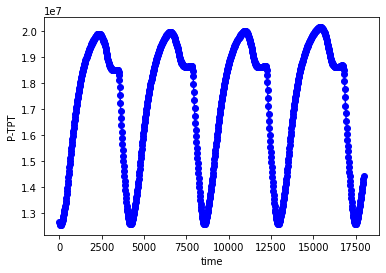

In [68]:
signal_sim_downsampled = pd.DataFrame(signal_sim_sampled,
                  index=index_sampled, columns=['P-TPT'])
plt.xlabel('time');
plt.ylabel('P-TPT');
plt.plot(signal_sim_downsampled.index,signal_sim_downsampled['P-TPT'], 'bo-')

In [73]:
print('length of signal to analyze', len(signal_sim_downsampled))

max_time_delay = 50 
max_embedding_dimension = 10
stride = 1

optimal_time_delay, optimal_embedding_dimension = takens_embedding_optimal_parameters(
    signal_sim_downsampled, max_time_delay, max_embedding_dimension, stride=stride
    )

print(f"Optimal embedding time delay based on mutual information: {optimal_time_delay}")
print(f"Optimal embedding dimension based on false nearest neighbors: {optimal_embedding_dimension}")

embedding_dimension = optimal_embedding_dimension
embedding_time_delay = optimal_time_delay

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

signal_sim_embedded = embedder.fit_transform(signal_sim_downsampled)

pca = PCA(n_components=3)
signal_sim_embedded_pca = pca.fit_transform(signal_sim_embedded)

plot_point_cloud(signal_sim_embedded_pca)

length of signal to analyze 900
Optimal embedding time delay based on mutual information: 31
Optimal embedding dimension based on false nearest neighbors: 10


In [76]:
signal_sim_embedded_reshaped = signal_sim_embedded.reshape(1, *signal_sim_embedded.shape)
print(f"y_wn_embedded_reshaped.shape",signal_sim_embedded_reshaped.shape)
print(f"y_wn_embedded.shape", signal_sim_embedded_reshaped.shape)

PerHom_sim_signal = VRP.fit_transform(signal_sim_embedded_reshaped)
features_sim = PE_slug.fit_transform(PerHom_signal)
features_sim_norm = PE_slug_norm.fit_transform(PerHom_signal)

y_wn_embedded_reshaped.shape (1, 621, 10)
y_wn_embedded.shape (1, 621, 10)


In [77]:
features_sim

array([[8.85156327, 2.40306284, 4.83440879]])

In [78]:
features_sim_norm

array([[0.36769906, 0.11765671, 0.27278366]])

In [79]:
VRP.plot(PerHom_sim_signal)

In [82]:
PerHom_sim_signal.shape

(1, 919, 3)

In [89]:
PerHom_signal.shape

#tmp = np.vstack([PerHom_signal,PerHom_sim_signal])
#tmp.shape

(1, 533, 3)

In [94]:
diagramScaler = Scaler()
PerHom_signal_scaled = diagramScaler.fit_transform(PerHom_signal)
diagramScaler.plot(PerHom_signal_scaled)

In [92]:
PerHom_signal_sim_scaled = diagramScaler.fit_transform(PerHom_sim_signal)
diagramScaler.plot(PerHom_signal_sim_scaled)

In [95]:
features_sim = PE_slug.fit_transform(PerHom_signal_scaled)
features_sim_norm = PE_slug_norm.fit_transform(PerHom_signal_scaled)
features_sim

array([[8.85156327, 2.40306284, 4.83440879]])

In [96]:
features_sim_norm

array([[  1.49319727,   1.05423515, -11.44457834]])

In [111]:
HK = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1) 
HK_slug = HK.fit_transform_plot(PerHom_signal_scaled, homology_dimension_idx=1)

In [112]:
HK.fit_transform_plot(PerHom_signal_sim_scaled, homology_dimension_idx=1)

array([[[[ 5.07638691e+02,  4.99572666e+02,  4.91460183e+02, ...,
           1.66820580e+01,  8.32249323e+00,  0.00000000e+00],
         [ 5.00163881e+02,  4.92070493e+02,  4.83931025e+02, ...,
           8.36008392e+00,  0.00000000e+00, -8.32249323e+00],
         [ 4.92624107e+02,  4.84503736e+02,  4.76337670e+02, ...,
           0.00000000e+00, -8.36008392e+00, -1.66820580e+01],
         ...,
         [ 1.78456729e+01,  8.93264763e+00,  0.00000000e+00, ...,
          -4.76337670e+02, -4.83931025e+02, -4.91460183e+02],
         [ 8.91354577e+00,  0.00000000e+00, -8.93264763e+00, ...,
          -4.84503736e+02, -4.92070493e+02, -4.99572666e+02],
         [ 0.00000000e+00, -8.91354577e+00, -1.78456729e+01, ...,
          -4.92624107e+02, -5.00163881e+02, -5.07638691e+02]],

        [[ 6.89021565e+00,  6.71087491e+00,  6.20037748e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 7.07434908e+00,  6.89021565e+00,  6.36607574e+00, ...,
           0.00000000e